# Used car's price prediction
**Задача** - разработать модель для предсказания стоимости продажи автомобиля на вторичном рынке.

**Данные**
- *train.csv* - информация о продажах (~440000) автомобилей с аукционов, которые будут использоваться в качестве обучающих данных.
- *test.csv* - информация о продажах (~110000) автомобилей с аукционов, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'sellingprice' для каждого автомобиля из этого датасета.

- *vin* - идентификатор каждого автомобиля в тестовом наборе.
- *sellingprice* - Целевой признак. Для каждого автомобиля предскажите числовое значение стоимости автомобиля.

**Описание полей данных**
- 'year' - год производства
- 'make' - производитель
- 'model' - модель
- 'trim' - модификация
- 'body' - тип кузова
- 'transmission' - тип КПП
- 'vin' - идентификатор (вин)
- 'state' - штат регистрации
- 'condition' - состояние по шкале (1-5)
- 'odometer' - пробег в милях
- 'color' - цвет кузова
- 'interior' - цвет интерьера
- 'seller' - продавец
- 'sellingprice' - стоимость продажи
- 'saledate' - дата продажи

**План работы:**
1. загрузка и ознакомление с данными,
2. подготовка данных,
3. feature engineering and feature extrac_on
4. обучение модели и формирование предсказаний,
5. подготовка отсчета по исследованию.

In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import catboost

In [29]:
from catboost import CatBoostRegressor, Pool

In [30]:
df_train = pd.read_csv('train.csv.zip')
df_test = pd.read_csv('test.csv.zip')

In [31]:
df_train.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'sellingprice',
       'saledate'],
      dtype='object')

Извлечем из даты день недели, месяц, год и день.

In [32]:
df_train['day_of_week'] = df_train['saledate'].str[:3]
df_test['day_of_week'] = df_test['saledate'].str[:3]

In [33]:
df_train['month'] = df_train['saledate'].str[4:7]
df_test['month'] = df_train['saledate'].str[4:7]


In [34]:
df_train['day'] = df_train['saledate'].str[8:10]
df_test['day'] = df_test['saledate'].str[8:10]



In [35]:
df_train['year_sold'] = df_train['saledate'].str[11:15]
df_test['year_sold'] = df_test['saledate'].str[11:15]


Заполним пропуски в категориальных значениях

In [36]:
df_train['color'] = df_train['color'].fillna('—')
df_train['interior'] = df_train['interior'].fillna('—')
df_test['color'] = df_test['color'].fillna('—')
df_test['interior'] = df_test['interior'].fillna('—')

Поменяем регистр значений, чтобы избавиться от неявных дублей

In [37]:
for col in ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']:
    df_train[col] = df_train[col].str.upper()
    df_test[col] = df_test[col].str.upper()

In [38]:
train_cols = [
    'year', 
    'make',
    'model', 
    'trim', 
    'body', 
    'transmission',
    'state', 
    'condition', 
    'odometer', 
    'color', 
    'interior', 
    'day',
    'month',
    'year_sold',
    'day_of_week'
    #'seller'
]

n_rows = len(df_train)
val_fraction = 0.1
traintrain_rows = n_rows * (1-val_fraction)

X_train_all = df_train[train_cols]
y_train_all = df_train['sellingprice']


X_train_all_orig = X_train_all.copy()

X_test = df_test[train_cols]

Меняем тип данных для обработки

In [39]:
nocat_cols = [
    'odometer',
    'condition'
]

cat_cols = set(train_cols) - set(nocat_cols)
for col in cat_cols:
    print(col)
    X_train_all[col] = X_train_all[col].astype('string')
    X_test[col] = X_test[col].astype('string')

    X_train_all[col] = X_train_all[col].fillna(value='')
    X_test[col] = X_test[col].fillna(value='')

day
body


/tmp/ipykernel_3298100/1183220046.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_all[col] = X_train_all[col].astype('string')
/tmp/ipykernel_3298100/1183220046.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('string')
/tmp/ipykernel_3298100/1183220046.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

make
state
trim
color
month
day_of_week
interior
model
year_sold
transmission
year


In [40]:
X_train = X_train_all.loc[:traintrain_rows]
X_val = X_train_all.loc[traintrain_rows:]

y_train = y_train_all.loc[:traintrain_rows]
y_val = y_train_all.loc[traintrain_rows:]

In [41]:
#X_train_s = X_train[:1000]
#y_train_s = y_train[:1000]

In [42]:
train_all_cb = Pool(
    X_train_all,
    label=y_train_all,
    cat_features=list(cat_cols)
)

train_cb = Pool(
    X_train,
    label=y_train,
    cat_features=list(cat_cols)
)

val_cb = Pool(
    X_val,
    label=y_val,
    cat_features=list(cat_cols)
)

test_cb = Pool(
    X_test,
    cat_features=list(cat_cols)
)

In [52]:
model = CatBoostRegressor(
    iterations=500, 
    depth=16, 
    learning_rate=0.2,
    loss_function='RMSE',
    eval_metric='MAPE',
    l2_leaf_reg=0.3,
)

In [ ]:
model.grid_search(
    {
        'learning_rate':[3e-2, 1e-1, 2e-1],
        'depth':[8,9,10],
        'l2_leaf_reg': [0.1, 0.3, 0.5],
        #"boosting_type": ["Ordered", "Plain"],
        #"bootstrap_type": ["Bayesian", "Bernoulli", "MVS"],
        #border_count':[10,50,100,200]
        
    },
    train_cb, 
    cv=5
)

In [21]:
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error

In [54]:
y_pred = model.predict(val_cb)
median_error = median_absolute_error(y_pred, y_val)
mape = mean_absolute_percentage_error(y_pred, y_val)
print(f"median error: {median_error}")
print(f"mape: {mape}")

median error: 741.5499314786357
mape: 0.17290601421750962


In [51]:
res = df_test.copy()
res['sellingprice'] = model.predict(test_cb)
res_save = res[['vin', 'sellingprice']]
res_save.to_csv('submission9.csv', index=False)

Trial 1 без предобработки данных:
* median error: 890.6285973197455
* mape: 0.22913660324591179

BEst params:
* iterations=150, 
* depth=10,
* l2_leaf_reg=3,
* learning_rate=0.5,
* boosting_type='Plain',
* bootstrap_type='MVS',
* loss_function='RMSE',
* eval_metric='MAPE'

Trial 2 с предобработкой (заполнение пропусков, разбиение дат):

* mape: 18.48254

Best params:
* iterations=150, 
* depth=16, 
* learning_rate=0.2,
* loss_function='RMSE',
* eval_metric='MAPE',
* l2_leaf_reg=0.3,



Trial 3 iterations = 300:
* median error: 774.8727997496535
* mape: 0.17006999101748338

Best params:
* 'depth': 10, 
* 'learning_rate': 0.2, 
* 'l2_leaf_reg': 0.1

Text(0.5, 1.0, 'Feature Importance')

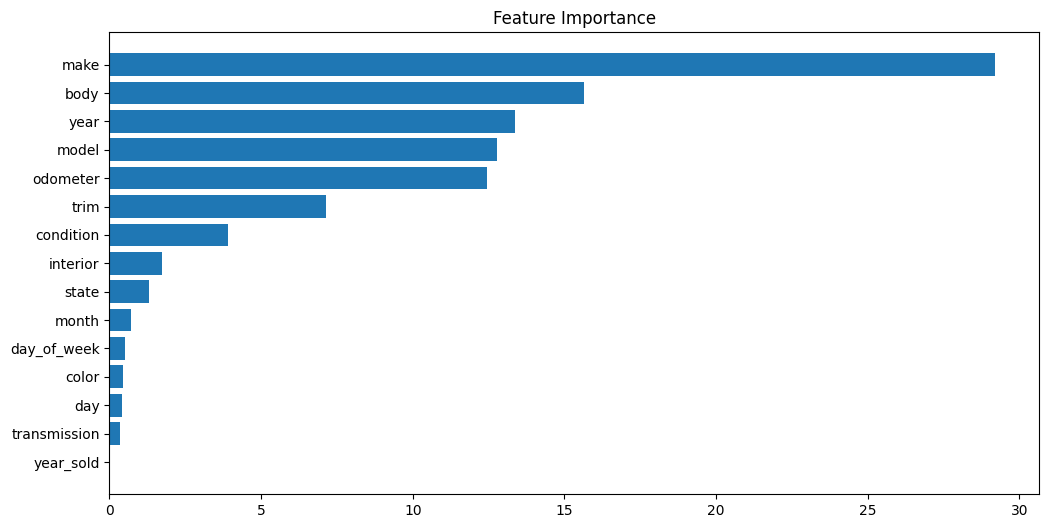

In [55]:

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


Самые важные фичи:
* make
* body
* year
* model
* odometer

Что можно посмотреть в будущем:
* перебрать большее количество параметров с помощью optuna
